In [15]:
import kagglehub
import os
from pathlib import Path
import pandas as pd

In [16]:
# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

data = path

paths = [path.parts[-2:] for path in
         Path(data).rglob('*.*')]                             #writing purpose ('*.*') so that all image formats can be retrieved
df = pd.DataFrame(data=paths, columns=['Class','Images'])     #create column names for dataframe
df = df.sort_values('Class',ascending=True)                   #sort class name
df.reset_index(drop=True, inplace=True)                       #sort index of each row
df                                                            #display dataframe

Path to dataset files: C:\Users\weare\.cache\kagglehub\datasets\msambare\fer2013\versions\1


,Class,Images
0,angry,PrivateTest_10131363.jpg
1,angry,Training_39549147.jpg
2,angry,Training_39537307.jpg
3,angry,Training_39536203.jpg
4,angry,Training_39520111.jpg
...,...,...
35882,surprise,Training_24659919.jpg
35883,surprise,Training_24676265.jpg
35884,surprise,Training_24694222.jpg
35885,surprise,Training_24121371.jpg


In [17]:
RANDOM_STATE = 42
IMAGE_SHAPE = (48, 48)
INPUT_SHAPE = (48, 48, 1)  # Grayscale images)
EPOCHS = 50
BATCH_SIZE = 32
NUM_CLASSES = 7

In [18]:
print(os.getcwd())
os.chdir(path)
print(os.getcwd())

C:\Users\weare\.cache\kagglehub\datasets\msambare\fer2013\versions\1
C:\Users\weare\.cache\kagglehub\datasets\msambare\fer2013\versions\1


In [19]:
print(os.listdir())
print(os.listdir("train"))

['test', 'train']
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [20]:
train_path = os.path.join(path, "train")
test_path = os.path.join(path, "test")

# EDA

In [21]:
class_names = os.listdir(train_path)
print("Class names:", class_names)
print("Number of classes:", len(class_names))

Class names: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7


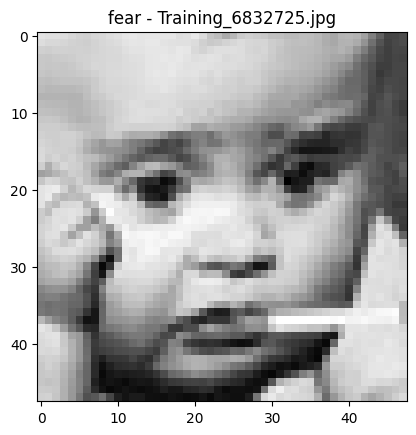

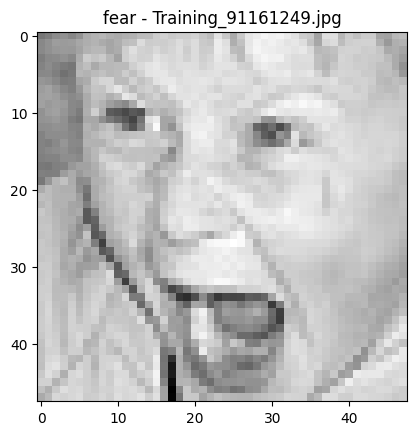

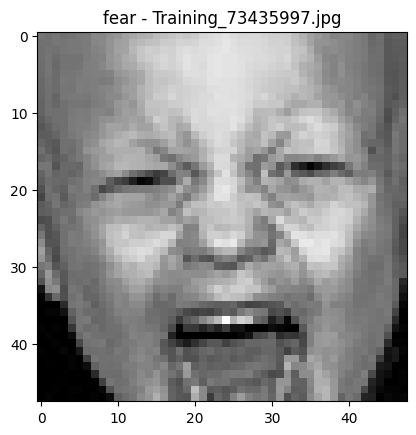

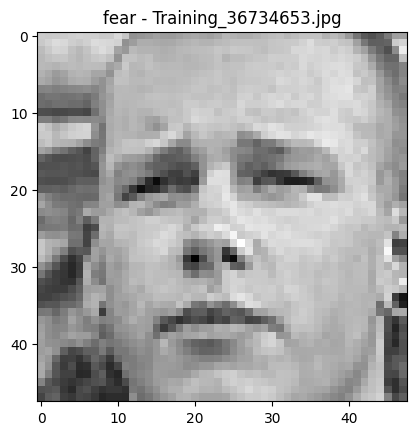

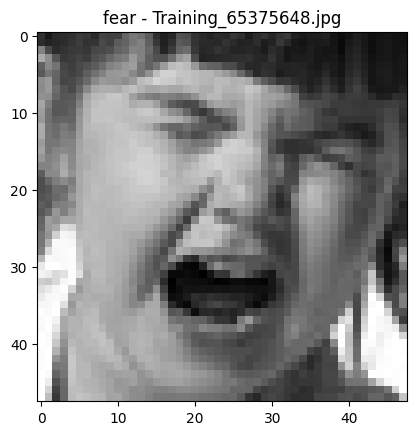

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def visualize_random_images(target_path, target_class):
    "Visualize random images from a exact directory"
    image_dir = os.path.join(target_path, target_class)
    random_images = random.sample(os.listdir(image_dir), 5)
    for image in random_images:
        image_path = os.path.join(image_dir, image)
        img = mpimg.imread(image_path)
        plt.imshow(img, cmap='gray')
        plt.title(f"{target_class} - {image}")
        plt.show()

# Visualize random images from the training set
visualize_random_images(train_path, random.choice(class_names))

# Create Datasets from directories

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [24]:
# Normalize images to [0, 1]
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Training data generator
train_data = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=IMAGE_SHAPE,         # (height, width)
    color_mode='grayscale',          # Use 1 channel
    class_mode='categorical',        # One-hot encoded labels
    batch_size=BATCH_SIZE,
    shuffle=True,                    # Shuffle for training
    seed=RANDOM_STATE
)

# Testing data generator
test_data = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=IMAGE_SHAPE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False                    # Do not shuffle for evaluation
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

print(class_weights)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

[1.02660468 9.40661861 1.00104606 0.56843877 0.82603942 0.84912748
 1.29337298]


{0: np.float64(1.0266046844269623),
 1: np.float64(9.406618610747051),
 2: np.float64(1.0010460615781582),
 3: np.float64(0.5684387684387684),
 4: np.float64(0.8260394187886635),
 5: np.float64(0.8491274770777877),
 6: np.float64(1.293372978330405)}

# Create and fit the model

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, LayerNormalization, GlobalAveragePooling2D
# Define the model architecture
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

model = Sequential(
    [
    Input(shape = INPUT_SHAPE),
    # 32
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same',),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 64
    Conv2D(64, (3, 3), activation='relu', padding='same',),
    LayerNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same',),
    LayerNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # 128
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    LayerNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same',),
    LayerNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),


    
    # Dense layers
    #Global Average Pooling layer is used instead of Flatten as it is more effiecient
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax') # Output layer with softmax activation
    ]
)

In [27]:
# define earlystopping callback
es = EarlyStopping(monitor = 'val_loss',
                                   min_delta = 0,
                                   patience = 3, 
                                   verbose = 1,
                                   restore_best_weights = True)

# define modelcheckpointt callback
cp = ModelCheckpoint(filepath = "ferNet.keras",
                     save_best_only = True,
                     verbose = 1,
                     mode = 'min')

CALLBACKS  = [cp, es]

In [28]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall(name='recall')]
)

H = model.fit(
    train_data,
    validation_data = test_data,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    class_weight = class_weight_dict
)

Epoch 1/50


C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.97647065],
         [0.95294124],
         [0.9450981 ],
         ...,
         [0.97647065],
         [0.98823535],
         [0.9843138 ]],

        [[0.9686275 ],
         [0.9607844 ],
         [0.9215687 ],
         ...,
         [0.97647065],
         [0.9843138 ],
         [0.98823535]],

        [[0.96470594],
         [0.9607844 ],
         [0.91372555],
         ...,
         [0.9725491 ],
         [0.9803922 ],
         [0.9921569 ]],

        ...,

        [[0.9803922 ],
         [0.9843138 ],
         [0.9607844 ],
         ...,
         [0.68235296],
         [0.7294118 ],
         [0.7686275 ]],

        [[0.9490197 ],
         [0.8980393 ],
         [0.8588236 ],
         ...,
         [0.6666667 ],
         [0.7176471 ],
         [0.7607844 ]],

        [[0.8352942 ],
         [0.8196079 ],
         [0.8862746 ],
         ...,
         [0.67058825],
         [0.7254902 ],
         [0.76470596]]],


       [[[0.07843138],
         [0.06666667],
         [0.09019608],
         ...,
         [0.24705884],
         [0.2509804 ],
         [0.34117648]],

        [[0.10196079],
         [0.08235294],
         [0.05882353],
         ...,
         [0.29803923],
         [0.39607847],
         [0.45098042]],

        [[0.10588236],
         [0.10196079],
         [0.07058824],
         ...,
         [0.454902  ],
         [0.5019608 ],
         [0.47450984]],

        ...,

        [[0.69411767],
         [0.69411767],
         [0.6784314 ],
         ...,
         [0.61960787],
         [0.64705884],
         [0.6431373 ]],

        [[0.7019608 ],
         [0.7058824 ],
         [0.68235296],
         ...,
         [0.5882353 ],
         [0.6156863 ],
         [0.60784316]],

        [[0.7058824 ],
         [0.6901961 ],
         [0.70980394],
         ...,
         [0.60784316],
         [0.6       ],
         [0.5882353 ]]],


       [[[0.7411765 ],
         [0.74509805],
         [0.7568628 ],
         ...,
         [0.3647059 ],
         [0.64705884],
         [0.7372549 ]],

        [[0.75294125],
         [0.75294125],
         [0.7490196 ],
         ...,
         [0.15686275],
         [0.32156864],
         [0.64705884]],

        [[0.7372549 ],
         [0.7372549 ],
         [0.73333335],
         ...,
         [0.2627451 ],
         [0.43137258],
         [0.654902  ]],

        ...,

        [[0.02745098],
         [0.03529412],
         [0.07058824],
         ...,
         [0.70980394],
         [0.7058824 ],
         [0.69803923]],

        [[0.06666667],
         [0.06666667],
         [0.05882353],
         ...,
         [0.7058824 ],
         [0.6862745 ],
         [0.70980394]],

        [[0.06666667],
         [0.0627451 ],
         [0.06666667],
         ...,
         [0.69411767],
         [0.7137255 ],
         [0.6901961 ]]],


       ...,


       [[[0.36862746],
         [0.04313726],
         [0.02352941],
         ...,
         [0.18431373],
         [0.54901963],
         [1.        ]],

        [[0.2901961 ],
         [0.1137255 ],
         [0.02745098],
         ...,
         [0.18823531],
         [0.40784317],
         [0.8941177 ]],

        [[0.5176471 ],
         [0.18039216],
         [0.01568628],
         ...,
         [0.24313727],
         [0.40000004],
         [0.8588236 ]],

        ...,

        [[0.9921569 ],
         [1.        ],
         [0.9960785 ],
         ...,
         [0.9215687 ],
         [0.96470594],
         [0.9843138 ]],

        [[0.9843138 ],
         [0.9921569 ],
         [0.96470594],
         ...,
         [0.8941177 ],
         [0.92549026],
         [0.9568628 ]],

        [[0.9960785 ],
         [0.95294124],
         [0.909804  ],
         ...,
         [0.8941177 ],
         [0.93725497],
         [0.92549026]]],


       [[[0.90196085],
         [0.90196085],
         [0.9215687 ],
         ...,
         [0.26666668],
         [0.2627451 ],
         [0.26666668]],

        [[0.9058824 ],
         [0.90196085],
         [0.89019614],
         ...,
         [0.25882354],
         [0.2509804 ],
         [0.25882354]],

        [[0.89019614],
         [0.91372555],
         [0.9176471 ],
         ...,
         [0.25882354],
         [0.25882354],
         [0.26666668]],

        ...,

        [[0.86666673],
         [0.87843144],
         [0.8705883 ],
         ...,
         [0.16862746],
         [0.16470589],
         [0.18431373]],

        [[0.8745099 ],
         [0.85098046],
         [0.8980393 ],
         ...,
         [0.14117648],
         [0.16470589],
         [0.20392159]],

        [[0.86274517],
         [0.87843144],
         [0.8431373 ],
         ...,
         [0.14901961],
         [0.19607845],
         [0.27058825]]],


       [[[0.25882354],
         [0.27058825],
         [0.25490198],
         ...,
         [0.21960786],
         [0.20392159],
         [0.20392159]],

        [[0.25882354],
         [0.2627451 ],
         [0.28235295],
         ...,
         [0.227451  ],
         [0.21176472],
         [0.20392159]],

        [[0.27450982],
         [0.25882354],
         [0.29411766],
         ...,
         [0.227451  ],
         [0.22352943],
         [0.21568629]],

        ...,

        [[0.07450981],
         [0.10588236],
         [0.14509805],
         ...,
         [0.1254902 ],
         [0.08627451],
         [0.05490196]],

        [[0.08235294],
         [0.10588236],
         [0.13725491],
         ...,
         [0.13333334],
         [0.09803922],
         [0.06666667]],

        [[0.08627451],
         [0.10588236],
         [0.13333334],
         ...,
         [0.13333334],
         [0.10196079],
         [0.07450981]]]], dtype=float32), array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)).
Traceback (most recent call last):

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 204, in generator_py_func
    flattened_values = nest.flatten_up_to(output_types, values)
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\util\nest.py", line 237, in flatten_up_to
    return nest_util.flatten_up_to(
           ^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\util\nest_util.py", line 1541, in flatten_up_to
    return _tf_data_flatten_up_to(shallow_tree, input_tree)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\util\nest_util.py", line 1570, in _tf_data_flatten_up_to
    _tf_data_assert_shallow_structure(shallow_tree, input_tree)

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\util\nest_util.py", line 1427, in _tf_data_assert_shallow_structure
    raise ValueError(

ValueError: The two structures don't have the same sequence length. Input structure has length 2, while shallow structure has length 3.


The above exception was the direct cause of the following exception:


Traceback (most recent call last):

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\ops\script_ops.py", line 269, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "C:\Users\weare\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 206, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element that did not match the expected structure. The expected structure was (tf.float32, tf.float32, tf.float32), but the yielded element was (array([[[[0.97647065],
         [0.95294124],
         [0.9450981 ],
         ...,
         [0.97647065],
         [0.98823535],
         [0.9843138 ]],

        [[0.9686275 ],
         [0.9607844 ],
         [0.9215687 ],
         ...,
         [0.97647065],
         [0.9843138 ],
         [0.98823535]],

        [[0.96470594],
         [0.9607844 ],
         [0.91372555],
         ...,
         [0.9725491 ],
         [0.9803922 ],
         [0.9921569 ]],

        ...,

        [[0.9803922 ],
         [0.9843138 ],
         [0.9607844 ],
         ...,
         [0.68235296],
         [0.7294118 ],
         [0.7686275 ]],

        [[0.9490197 ],
         [0.8980393 ],
         [0.8588236 ],
         ...,
         [0.6666667 ],
         [0.7176471 ],
         [0.7607844 ]],

        [[0.8352942 ],
         [0.8196079 ],
         [0.8862746 ],
         ...,
         [0.67058825],
         [0.7254902 ],
         [0.76470596]]],


       [[[0.07843138],
         [0.06666667],
         [0.09019608],
         ...,
         [0.24705884],
         [0.2509804 ],
         [0.34117648]],

        [[0.10196079],
         [0.08235294],
         [0.05882353],
         ...,
         [0.29803923],
         [0.39607847],
         [0.45098042]],

        [[0.10588236],
         [0.10196079],
         [0.07058824],
         ...,
         [0.454902  ],
         [0.5019608 ],
         [0.47450984]],

        ...,

        [[0.69411767],
         [0.69411767],
         [0.6784314 ],
         ...,
         [0.61960787],
         [0.64705884],
         [0.6431373 ]],

        [[0.7019608 ],
         [0.7058824 ],
         [0.68235296],
         ...,
         [0.5882353 ],
         [0.6156863 ],
         [0.60784316]],

        [[0.7058824 ],
         [0.6901961 ],
         [0.70980394],
         ...,
         [0.60784316],
         [0.6       ],
         [0.5882353 ]]],


       [[[0.7411765 ],
         [0.74509805],
         [0.7568628 ],
         ...,
         [0.3647059 ],
         [0.64705884],
         [0.7372549 ]],

        [[0.75294125],
         [0.75294125],
         [0.7490196 ],
         ...,
         [0.15686275],
         [0.32156864],
         [0.64705884]],

        [[0.7372549 ],
         [0.7372549 ],
         [0.73333335],
         ...,
         [0.2627451 ],
         [0.43137258],
         [0.654902  ]],

        ...,

        [[0.02745098],
         [0.03529412],
         [0.07058824],
         ...,
         [0.70980394],
         [0.7058824 ],
         [0.69803923]],

        [[0.06666667],
         [0.06666667],
         [0.05882353],
         ...,
         [0.7058824 ],
         [0.6862745 ],
         [0.70980394]],

        [[0.06666667],
         [0.0627451 ],
         [0.06666667],
         ...,
         [0.69411767],
         [0.7137255 ],
         [0.6901961 ]]],


       ...,


       [[[0.36862746],
         [0.04313726],
         [0.02352941],
         ...,
         [0.18431373],
         [0.54901963],
         [1.        ]],

        [[0.2901961 ],
         [0.1137255 ],
         [0.02745098],
         ...,
         [0.18823531],
         [0.40784317],
         [0.8941177 ]],

        [[0.5176471 ],
         [0.18039216],
         [0.01568628],
         ...,
         [0.24313727],
         [0.40000004],
         [0.8588236 ]],

        ...,

        [[0.9921569 ],
         [1.        ],
         [0.9960785 ],
         ...,
         [0.9215687 ],
         [0.96470594],
         [0.9843138 ]],

        [[0.9843138 ],
         [0.9921569 ],
         [0.96470594],
         ...,
         [0.8941177 ],
         [0.92549026],
         [0.9568628 ]],

        [[0.9960785 ],
         [0.95294124],
         [0.909804  ],
         ...,
         [0.8941177 ],
         [0.93725497],
         [0.92549026]]],


       [[[0.90196085],
         [0.90196085],
         [0.9215687 ],
         ...,
         [0.26666668],
         [0.2627451 ],
         [0.26666668]],

        [[0.9058824 ],
         [0.90196085],
         [0.89019614],
         ...,
         [0.25882354],
         [0.2509804 ],
         [0.25882354]],

        [[0.89019614],
         [0.91372555],
         [0.9176471 ],
         ...,
         [0.25882354],
         [0.25882354],
         [0.26666668]],

        ...,

        [[0.86666673],
         [0.87843144],
         [0.8705883 ],
         ...,
         [0.16862746],
         [0.16470589],
         [0.18431373]],

        [[0.8745099 ],
         [0.85098046],
         [0.8980393 ],
         ...,
         [0.14117648],
         [0.16470589],
         [0.20392159]],

        [[0.86274517],
         [0.87843144],
         [0.8431373 ],
         ...,
         [0.14901961],
         [0.19607845],
         [0.27058825]]],


       [[[0.25882354],
         [0.27058825],
         [0.25490198],
         ...,
         [0.21960786],
         [0.20392159],
         [0.20392159]],

        [[0.25882354],
         [0.2627451 ],
         [0.28235295],
         ...,
         [0.227451  ],
         [0.21176472],
         [0.20392159]],

        [[0.27450982],
         [0.25882354],
         [0.29411766],
         ...,
         [0.227451  ],
         [0.22352943],
         [0.21568629]],

        ...,

        [[0.07450981],
         [0.10588236],
         [0.14509805],
         ...,
         [0.1254902 ],
         [0.08627451],
         [0.05490196]],

        [[0.08235294],
         [0.10588236],
         [0.13725491],
         ...,
         [0.13333334],
         [0.09803922],
         [0.06666667]],

        [[0.08627451],
         [0.10588236],
         [0.13333334],
         ...,
         [0.13333334],
         [0.10196079],
         [0.07450981]]]], dtype=float32), array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)).


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_multi_step_on_iterator_10858]

In [ ]:
emotion_model.evaluate(test_data)

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(10, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = emotion_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [ ]:
def load_and_resize_image(image_path, target_size=(48, 48)):
    "Load and resize an image to the target size"
    img = tf.keras.preprocessing.image.load_img(image_path, color_mode='grayscale', target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize the image
    return img_array